# &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;HACETTEPE UNIVERSITY COMPUTER ENGINEERING
## &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;  &emsp;&emsp;BBM 409 Machine Learning Lab
## &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;  &emsp;&emsp;&emsp;&emsp;  &emsp;&emsp;Assignmet I

### &emsp;Name/Surname: Oktay UĞURLU
### &emsp;School Number: 21627725
### &emsp;E-mail: b21627725@cs.hacettepe.edu.tr

### Sections
- [Part I: Classification of Images](#part_2)
    - [Filtering Methods](#filtering_methods)
    - [Preparing Data](#preparing_data)
    - [Implementation of KNN & Weighted KNN Algorithms](#implementing_knn)
    - [K-Fold Cross Validation Implementation](#implementing_kfold)
    - [Validation of Performance](#validation_of_performance)
    - [Evaluation of Models](#evaluation)



In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


<a id='part_2'></a>

# Part I: Classification of Images

In this assignment, the aim is implement K-Nearest Neighbors and Weighted K-Nearest Neighbors Classifier algorithms, and train a model that classifies the images to Covid, Normal and Viral Pneumonia classes. I have used 3 type of images to train the model. 
- The first type is, directly readed pixels of images
- The second one is, filtered images by gabor filter
- The last one is, filtered images by using canny edge detection

After these filtering operation, I compose these features with each other to feed my models. After, I use both K-Nearest Neighbors and Weighted K-Nearest Neighbors Classifier algorithms to train and test of these featured data in [Validation of Performance](#validation_of_performance) part. I also use K-Fold Cross Validation which is implemented by me, to find a model that gives best accuracy and has best performance.

In the [Evaluation of Models](#evaluation) part, I discussed these models and their accuracy results by using classification report and confusion matrix.

In [ ]:
import cv2
import pandas as pd
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import math
import operator
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt                              #For visualization
import seaborn as sns; sns.set() 

We set a fixed size to make all images as same pixel size. Because, the higher resolution data will affect the time complexity of feature extraction.

In [102]:
SIZE=64

<a id='filtering_methods'></a>
## 1-) Filtering Methods

In [103]:
# Grayscale
def BGR2GRAY(img):
    # Grayscale
    gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
    return gray

# Canny Edge dedection
def Canny_edge(img):
    canny_edges = cv2.Canny(np.uint8(img),100,200)
    return canny_edges

# Gabor Filter
def Gabor_filter(K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get half size
    d = K_size // 2

    # prepare kernel
    gabor = np.zeros((K_size, K_size), dtype=np.float32)

    # each value
    for y in range(K_size):
        for x in range(K_size):
            # distance from center
            px = x - d
            py = y - d

            # degree -> radian
            theta = angle / 180. * np.pi

            # get kernel x
            _x = np.cos(theta) * px + np.sin(theta) * py

            # get kernel y
            _y = -np.sin(theta) * px + np.cos(theta) * py

            # fill kernel
            gabor[y, x] = np.exp(-(_x**2 + Gamma**2 * _y**2) / (2 * Sigma**2)) * np.cos(2*np.pi*_x/Lambda + Psi)

    # kernel normalization
    gabor /= np.sum(np.abs(gabor))

    return gabor


# Use Gabor filter to act on the image
def Gabor_filtering(gray, K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get shape
    H, W = gray.shape

    # padding
    gray = np.pad(gray, (K_size//2, K_size//2), 'edge')

    # prepare out image
    out = np.zeros((H, W), dtype=np.float32)

    # get gabor filter
    gabor = Gabor_filter(K_size=K_size, Sigma=Sigma, Gamma=Gamma, Lambda=Lambda, Psi=0, angle=angle)
        
    # filtering
    for y in range(H):
        for x in range(W):
            out[y, x] = np.sum(gray[y : y + K_size, x : x + K_size] * gabor)

    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)

    return out


# Use 6 Gabor filters with different angles to perform feature extraction on the image
def Gabor_process(img):
    # get shape
    H, W, _ = img.shape

    # gray scale
    gray = BGR2GRAY(img).astype(np.float32)

    # define angle
    #As = [0, 45, 90, 135]
    As = [0,30,60,90,120,150]

    # prepare pyplot
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0.2)

    out = np.zeros([H, W], dtype=np.float32)

    # each angle
    for i, A in enumerate(As):
        # gabor filtering
        _out = Gabor_filtering(gray, K_size=9, Sigma=1.5, Gamma=1.2, Lambda=1, angle=A)

        # add gabor filtered image
        out += _out

    # scale normalization
    out = out / out.max() * 255
    out = out.astype(np.uint8)

    return out


<a id='preparing_data'></a>
## 2-) Preparing Data

 ### - Loading Images to Memory and Gabor Filtering:

I have load the data and apply gabor filtering to each dataset:

In [104]:
image_list_COVID = []
out_list_COVID_not_filtered = np.empty((0,SIZE*SIZE), dtype=float, order='C')
for i in range(1,961):
    # Read image
    imgCOVID=cv2.imread('dataset/COVID/COVID ('+str(i)+').PNG').astype(np.float32)
    image_list_COVID.append(imgCOVID)
    
image_list_NORMAL = []
for i in range(1,1074):
    # Read image
    img=cv2.imread('dataset/NORMAL/NORMAL ('+str(i)+').PNG').astype(np.float32)
    image_list_NORMAL.append(img)
    
image_list_VIRAL = []
for i in range(1,1077):
    # Read image
    imgVIRAL=cv2.imread('dataset/Viral Pneumonia/Viral Pneumonia ('+str(i)+').png').astype(np.float32)
    image_list_VIRAL.append(imgVIRAL)

In [113]:
# **** Gabor Filtering for COVID data **** #

out_list_COVID = np.empty((0,SIZE*SIZE), dtype=float, order='C')
out_list_COVID_not_filtered = np.empty((0,SIZE*SIZE), dtype=float, order='C')

for i in range(0,960):
    # gabor process
    resized_image = cv2.resize(image_list_COVID[i], (SIZE, SIZE))
    outCOVID = Gabor_process(resized_image)
    out_list_COVID = np.append(out_list_COVID, outCOVID.reshape(1, SIZE*SIZE), axis=0)
    resized_image = BGR2GRAY(resized_image)
    out_list_COVID_not_filtered = np.append(out_list_COVID_not_filtered, resized_image.reshape(1, SIZE*SIZE), axis=0)
    
    
# **** Gabor Filtering for NORMAL data **** #

out_list_NORMAL = np.empty((0,SIZE*SIZE ), dtype=float, order='C')
out_list_NORMAL_not_filtered = np.empty((0,SIZE*SIZE), dtype=float, order='C')
for i in range(0,1073):
    # gabor process
    resized_image = cv2.resize(image_list_NORMAL[i], (SIZE, SIZE))
    out = Gabor_process(cv2.resize(image_list_NORMAL[i], (SIZE, SIZE)))
    out_list_NORMAL = np.append(out_list_NORMAL, out.reshape(1, SIZE*SIZE ), axis=0)
    resized_image = BGR2GRAY(resized_image)
    out_list_NORMAL_not_filtered = np.append(out_list_NORMAL_not_filtered, resized_image.reshape(1, SIZE*SIZE), axis=0)

    
# **** Gabor Filtering for Viral Pneumonia data **** #

out_list_VIRAL = np.empty((0,SIZE*SIZE), dtype=float, order='C')
out_list_VIRAL_not_filtered = np.empty((0,SIZE*SIZE), dtype=float, order='C')
for i in range(0,1076):
    # gabor process
    resized_image = cv2.resize(image_list_VIRAL[i], (SIZE, SIZE))
    outVIRAL = Gabor_process(cv2.resize(image_list_VIRAL[i], (SIZE, SIZE)))
    out_list_VIRAL = np.append(out_list_VIRAL, outVIRAL.reshape(1, SIZE*SIZE), axis=0)
    resized_image = BGR2GRAY(resized_image)
    out_list_VIRAL_not_filtered = np.append(out_list_VIRAL_not_filtered, resized_image.reshape(1, SIZE*SIZE), axis=0)


<Figure size 432x288 with 0 Axes>

 ### - Canny Edge Detection:

Here, I have used the canny edge detection to filter the data:

In [114]:
canny_out_list_COVID = np.empty((0,SIZE*SIZE), dtype=float, order='C')
for i in range(0,960):
    #canny edge process
    out_canny = Canny_edge(cv2.resize(image_list_COVID[i], (SIZE, SIZE)))
    canny_out_list_COVID = np.append(canny_out_list_COVID, out_canny.reshape(1, SIZE*SIZE), axis=0)

canny_out_list_NORMAL = np.empty((0,SIZE*SIZE), dtype=float, order='C')
for i in range(0,1073):
    #canny edge process
    out_canny = Canny_edge(cv2.resize(image_list_NORMAL[i], (SIZE, SIZE)))
    canny_out_list_NORMAL = np.append(canny_out_list_NORMAL, out_canny.reshape(1, SIZE*SIZE), axis=0)

canny_out_list_VIRAL = np.empty((0,SIZE*SIZE), dtype=float, order='C')
for i in range(0,1076):
    #canny edge process
    out_canny = Canny_edge(cv2.resize(image_list_VIRAL[i], (SIZE, SIZE)))
    canny_out_list_VIRAL = np.append(canny_out_list_VIRAL, out_canny.reshape(1, SIZE*SIZE), axis=0)

### Creating Labels:

I create the labels as numeric for each row prepared by composing in order COVID, NORMAL and Viral Phenomenia. For COVID, I assign 1, for NORMAL, I assign 2, and for VIRAL, I assign 3:

In [115]:
#   Because the gabor filtering takes too many times, I save and read gabor filtered data here
#out_list_COVID = pd.read_csv ('COVID.csv', engine='python')
#out_list_VIRAL = pd.read_csv ('VIRAL.csv', engine='python')
#out_list_NORMAL = pd.read_csv ('NORMAL.csv', engine='python')

label_COVID_df = np.empty((960,1), dtype=float, order='C')
label_COVID_df[:] = 1

label_NORMAL_df = np.empty((1073,1), dtype=float, order='C')
label_NORMAL_df[:] = 2

label_VIRAL_df = np.empty((1076,1), dtype=float, order='C')
label_VIRAL_df[:] = 3

After, I compose my datasets to create features:

### Composing Gabor Filtering Features:

In [116]:
composed_feature_arr = np.concatenate((out_list_COVID, out_list_NORMAL))
composed_feature_arr = np.concatenate((composed_feature_arr, out_list_VIRAL))

In [117]:
composed_label_arr = np.concatenate((label_COVID_df, label_NORMAL_df))
composed_label_arr = np.concatenate((composed_label_arr, label_VIRAL_df))

In [118]:
composed_feature_arr = pd.DataFrame(composed_feature_arr)
composed_feature_arr[4096] = composed_label_arr
gabor_composed_data = composed_feature_arr

### Composing Not Filtered Image Features:

In [119]:
not_filtered_composed_feature_arr = np.concatenate((out_list_COVID_not_filtered, out_list_NORMAL_not_filtered))
not_filtered_composed_feature_arr = np.concatenate((not_filtered_composed_feature_arr, out_list_VIRAL_not_filtered))

not_filtered_composed_feature_arr = pd.DataFrame(not_filtered_composed_feature_arr)
not_filtered_composed_feature_arr[4096] = composed_label_arr
not_filtered_composed_data = not_filtered_composed_feature_arr

### Composing Not Filtered Image and Gabor Filtering Features:

In [120]:
not_filtered_gabor_composed_data = pd.concat([not_filtered_composed_data,gabor_composed_data], axis = 1)

### Composing Canny Edge Features:

In [121]:
canny_composed_feature_arr = np.concatenate((canny_out_list_COVID, canny_out_list_NORMAL))
canny_composed_feature_arr = np.concatenate((canny_composed_feature_arr, canny_out_list_VIRAL))

In [122]:
canny_composed_feature_arr = pd.DataFrame(canny_composed_feature_arr)
canny_composed_feature_arr[4096] = composed_label_arr
canny_composed_data = composed_feature_arr

### Composing Canny Edge and Gabor Filtering Features:

In [123]:
canny_gabor_composed_data = pd.concat([canny_composed_data,gabor_composed_data], axis = 1)

### Composing Not Filtered, Canny Edge and Gabor Filtering Features:

In [124]:
not_filtered_canny_gabor_composed_data = pd.concat([canny_gabor_composed_data,not_filtered_composed_data], axis = 1)

<a id='implementing_knn'></a>
## 4-) Implementation of KNN & Weighted KNN Algorithms

I implement both K-Nearest-Neighbour and Weighted-KNN algorithms as you can see below. Because the pandas dataframe is not efficient in sort operations and caluclations, I convert the data to numpy array by using dataframe_to_numpy() function which I implement, before running the algorithm.

While the caluculation of the distances from each rows was 1.5 second, after convertion, the runtime of the calculation became 0.10 second.

In [233]:
class KNN_Classification:
    trained_data = []
    #prediction_and_row_list is used to get index of tested data and its predicted label, after using it in error analysis 
    
    def __init__(self, k, prediction_and_row_index_list=[]):
        self.k = k
        self.prediction_and_row_index_list = []
    
    # Calculating distance
    def calculate_distances(self, trained_data_list, test_data):
        distance_array = np.sqrt(np.sum(np.square(np.subtract(trained_data_list, test_data)), axis = 1))
        return distance_array.reshape(distance_array.shape[0],-1)

    def check_key_existance_and_return_value(self, dictionary,key):
        if key in dictionary:
            return dictionary[key]
        else:
            return 0

    # Because of performance issues, I convert dataframes to numpy arrays to increase the calculation of distances.
    def dataframe_to_numpy(self, trained_data, trained_label, test_data):
        return (trained_data.to_numpy(), trained_label.to_numpy(), test_data.to_numpy())

    # Train
    def train(self, trained_data, trained_label):
        self.trained_data = trained_data.copy()
        self.trained_label = trained_label.copy()
        self.index_array = np.array([i for i in range(trained_data.shape[0])])
        #I convert 1-D data to 2-D data
        self.index_array = self.index_array.reshape(self.index_array.shape[0],-1)
    
    # Knn predict. test data should not contain label column
    def predict(self, test_data):
        prediction_list = []
        trained_data_array, trained_label_array, test_data_array = self.dataframe_to_numpy(self.trained_data, self.trained_label, test_data)
        for test_data_i in range(test_data_array.shape[0]):
            distance_index_array = self.calculate_distances(trained_data_array, test_data_array[test_data_i,:])
            # index_array which keeps indexes of used train data used in distance calculation are 
            # added as second column to find the label of this point easily in trained_label_array
            distance_index_array = np.append(distance_index_array, self.index_array, axis=1)
            
            nearest_n_distance_index_array = distance_index_array[distance_index_array[:,0].argsort()]
            label_numbers_dict = {}
            
            for nearest_n_distance_array_i in range(self.k):
                label_of_nearest_data = trained_label_array[int(nearest_n_distance_index_array[nearest_n_distance_array_i,1])]
                label_numbers_dict[label_of_nearest_data] = self.check_key_existance_and_return_value(label_numbers_dict, label_of_nearest_data) + 1
            predicted_label = max(label_numbers_dict.items(), key=operator.itemgetter(1))[0]
            prediction_list.append(predicted_label)
            self.prediction_and_row_index_list.append([test_data.index[test_data_i], predicted_label])
        return pd.DataFrame(prediction_list)

In [241]:
class Weighted_KNN_Classification:
    trained_data = []
    #prediction_and_row_list is used to get index of tested data and its predicted label, after using it in error analysis 
    
    def __init__(self, k, prediction_and_row_index_list=[]):
        self.k = k
        self.prediction_and_row_index_list = []
    
    # Train
    def train(self, trained_data, trained_label):
        self.trained_data = trained_data.copy()
        self.trained_label = trained_label.copy()
        self.index_array = np.array([i for i in range(trained_data.shape[0])])
        self.index_array = self.index_array.reshape(self.index_array.shape[0],-1)
    
    # Calculating distance
    def calculate_distances(self, trained_data_list, test_data):
        distance_array = np.sqrt(np.sum(np.square(np.subtract(trained_data_list, test_data)), axis = 1))
        return distance_array.reshape(distance_array.shape[0],-1)
    
   # inverse square distance formula
    def calculate_weight(self, distance):
        return 1 / (distance)
    
    def check_key_existance_and_return_value(self, dictionary,key):
        if key in dictionary:
            return dictionary[key]
        else:
            return 0
        
    def sum_weights_of_each_group(self, distance_and_index_array, label_array):
        label_weight_dict = {}
        for row in range(self.k):
            label = label_array[int(distance_and_index_array[row,1])]
            label_weight_dict[label] = self.check_key_existance_and_return_value(label_weight_dict, label) + self.calculate_weight(distance_and_index_array[row,0])
        return label_weight_dict

    def convert_dataframe_to_numpy(self, trained_data, trained_label, test_data):
        return (trained_data.to_numpy(), trained_label.to_numpy(), test_data.to_numpy())
    
    # Knn predict. test data should not contain label column
    def predict(self, test_data):
        prediction_list = []
        trained_data_array, trained_label_array, test_data_array = self.convert_dataframe_to_numpy(self.trained_data, self.trained_label, test_data)
        for test_data_i in range(test_data_array.shape[0]):
            distance_index_array = self.calculate_distances(trained_data_array, test_data_array[test_data_i,:])

            # Indexes of used train data used in distance calculation are added as second column
            # to find the label of this point easily in trained_label_array
            distance_index_array = np.append(distance_index_array, self.index_array, axis=1)
            nearest_n_distance_index_array = distance_index_array[distance_index_array[:,0].argsort()][:self.k]
            
            label_numbers_dict = self.sum_weights_of_each_group(nearest_n_distance_index_array, trained_label_array)
            predicted_label = max(label_numbers_dict.items(), key=operator.itemgetter(1))[0]
            prediction_list.append(predicted_label)
            self.prediction_and_row_index_list.append([test_data.index[test_data_i], predicted_label])
        return pd.DataFrame(prediction_list)       
    


<a id='implementing_kfold'></a>
## 5-) K-Fold Cross Validation Implementation

I implemented the K-Fold cross validation algorithm. Also, I develop the accuracy calculator to use in my code. Also, I assign the k parameter which is number of splittings as 5 and use this default value for my training part, as the 5 gives the best performance:

In [127]:
# I calculate the accuracy by dividing the number of correctly classified examples of number of examples

def accuracy(predicted_labels, actual_label):
    # Because the actual labels index is not start from 0, I resett its index
    actual_label = actual_label.reset_index(drop=True).to_frame()
    actual_label.columns = [0]
    difference = predicted_labels.sub(actual_label)
    return difference[difference.iloc[:,0]==0].shape[0] / actual_label.shape[0]

def split_data(data_array, k):
    data_number_in_each_bucket = len(data_array)//k
    start_index_of_bucket=0
    end_index_of_bucket=data_number_in_each_bucket
    splitted_data_list=[]
    for i in range(0,k):
        if(i==k-1):
            splitted_data_list.append(data_array[start_index_of_bucket:])
        else:
            splitted_data_list.append(data_array[start_index_of_bucket:end_index_of_bucket])
            start_index_of_bucket = end_index_of_bucket
            end_index_of_bucket += data_number_in_each_bucket
    return splitted_data_list

def k_fold_cross_validation(model, data_df, k=5):
    data_df = data_df.sample(frac=1).reset_index(drop=True)
    splitted_data_list = split_data(data_df, k)
    total_accuracy = 0
    for test_data_index in range(0,k):
        train_data_list = splitted_data_list.copy()
        train_data_list.pop(test_data_index)
        
        train_data = pd.concat(train_data_list, ignore_index=True)
        test_data = splitted_data_list[test_data_index]
        knn.train(train_data.iloc[:,:-1], train_data.iloc[:,-1])
        prediction_array = knn.predict(test_data.iloc[:,:-1])
        total_accuracy += accuracy(prediction_array, test_data.iloc[:,-1])
    return total_accuracy/k


<a id='validation_of_performance'></a>
## 6-) Validation of Performance

In this part, I tried to find best model for different featured data and k values by using both k-fold cross validation and train-test method. I didn't use k-fold cross validation to find best k values for each model because its time complexity. There are 6 number different featured data, and I validate these by using both weighted k-nearest algorithm and normal k-nearest algorithm. I only try odd and not divisible by 3 numbers because the number of features are 3:

- **KNN algorithm** for **not filtered** features:

In [89]:
#Here, I split my data as train and test to find best k parameter. The test data constitutes of 30% of dataset
test_split_ratio = 3
#Shuffling the dataframe
data_df = not_filtered_composed_data.sample(frac=1).reset_index(drop=True)

test_start_index = int(data_df.shape[0] - data_df.shape[0] * test_split_ratio/10)
k_value_list = [1,5,7,11,13,17]
accuracy_k_dict = {}
for selected_k in k_value_list:
    knn = KNN_Classification(selected_k)
    #Train data
    knn.train(data_df.iloc[:test_start_index,:-1], data_df.iloc[:test_start_index,-1])
    #Predict labels
    prediction_array = knn.predict(data_df.iloc[test_start_index:,:-1])
    #Accuracy calculation
    accuracy_k_dict[selected_k] = accuracy(prediction_array, data_df.iloc[test_start_index:,-1])

max_k = max(accuracy_k_dict.items(), key=operator.itemgetter(1))[0]
print("Maximum k: "+ str(max_k))
print("Accuracy: "+ str(accuracy_k_dict[max_k]))

Maximum k: 17
Accuracy: 0.9121114683815649


In [145]:
not_filtered_knn = KNN_Classification(max_k)
not_filtered_knn_accuracy=k_fold_cross_validation(not_filtered_knn, not_filtered_composed_data)
print("K-Fold Accuracy: "+ str(not_filtered_knn_accuracy))

K-Fold Accuracy: 0.9096207379717504


- **Weighted KNN** algorithm for **not filtered** features:

In [91]:
#Here, I split my data as train and test to find best k parameter. The test data constitutes of 30% of dataset
test_split_ratio = 3
#Shuffling the dataframe
data_df = not_filtered_composed_data.sample(frac=1).reset_index(drop=True)

test_start_index = int(data_df.shape[0] - data_df.shape[0] * test_split_ratio/10)
k_value_list = [1,5,7,11,13,17]
accuracy_k_dict = {}
for selected_k in k_value_list:
    knn = Weighted_KNN_Classification(selected_k)
    knn.train(data_df.iloc[:test_start_index,:-1], data_df.iloc[:test_start_index,-1])
    prediction_array = knn.predict(data_df.iloc[test_start_index:,:-1])
    accuracy_k_dict[selected_k] = accuracy(prediction_array, data_df.iloc[test_start_index:,-1])

max_k = max(accuracy_k_dict.items(), key=operator.itemgetter(1))[0]
print("Maximum k: "+ str(max_k))
print("Accuracy: "+ str(accuracy_k_dict[max_k]))

Maximum k: 11
Accuracy: 0.9056806002143623


In [146]:
weighted_not_filtered_knn = Weighted_KNN_Classification(max_k)
weighted_not_filtered_knn_accuracy = k_fold_cross_validation(weighted_not_filtered_knn, not_filtered_composed_data)
print("K-Fold Accuracy: "+ str(weighted_not_filtered_knn_accuracy))

K-Fold Accuracy: 0.910261446182372


- **KNN algorithm** for **gabor filtering** features:

In [93]:
#Here, I split my data as train and test to find best k parameter. The test data constitutes of 30% of dataset
test_split_ratio = 3
#Shuffling the dataframe
data_df = gabor_composed_data.sample(frac=1).reset_index(drop=True)

test_start_index = int(data_df.shape[0] - data_df.shape[0] * test_split_ratio/10)
k_value_list = [1,5,7,11,13,17]
accuracy_k_dict = {}
for selected_k in k_value_list:
    knn = KNN_Classification(selected_k)
    knn.train(data_df.iloc[:test_start_index,:-1], data_df.iloc[:test_start_index,-1])
    prediction_array = knn.predict(data_df.iloc[test_start_index:,:-1])
    accuracy_k_dict[selected_k] = accuracy(prediction_array, data_df.iloc[test_start_index:,-1])

max_k = max(accuracy_k_dict.items(), key=operator.itemgetter(1))[0]
print("Maximum k: "+ str(max_k))
print("Accuracy: "+ str(accuracy_k_dict[max_k]))

Maximum k: 11
Accuracy: 0.9356913183279743


In [147]:
gabor_knn = KNN_Classification(max_k)
gabor_knn_accuracy = k_fold_cross_validation(gabor_knn, gabor_composed_data)
print("K-Fold Accuracy: "+ str(gabor_knn_accuracy))

K-Fold Accuracy: 0.9179815922824601


- **Weighted KNN** algorithm for **gabor filtering** features:

In [95]:
#Here, I split my data as train and test to find best k parameter. The test data constitutes of 30% of dataset
test_split_ratio = 3
#Shuffling the dataframe
data_df = gabor_composed_data.sample(frac=1).reset_index(drop=True)

test_start_index = int(data_df.shape[0] - data_df.shape[0] * test_split_ratio/10)

k_value_list = [1,3,5,7,9,11,13,15]
accuracy_k_dict = {}
for selected_k in k_value_list:
    knn = Weighted_KNN_Classification(selected_k)
    knn.train(data_df.iloc[:test_start_index,:-1], data_df.iloc[:test_start_index,-1])
    prediction_array = knn.predict(data_df.iloc[test_start_index:,:-1])
    accuracy_k_dict[selected_k] = accuracy(prediction_array, data_df.iloc[test_start_index:,-1])

max_k = max(accuracy_k_dict.items(), key=operator.itemgetter(1))[0]
print("Maximum k: "+ str(max_k))
print("Accuracy: "+ str(accuracy_k_dict[max_k]))

Maximum k: 5
Accuracy: 0.9260450160771704


In [148]:
weighted_gabor_knn = Weighted_KNN_Classification(max_k)
weighted_gabor_knn_accuracy = k_fold_cross_validation(weighted_gabor_knn, gabor_composed_data)
print("K-Fold Accuracy: "+ str(weighted_gabor_knn_accuracy))

K-Fold Accuracy: 0.9211984749593235


- **KNN algorithm** for **not filtered and gabor filtering** features:

In [97]:
#Here, I split my data as train and test to find best k parameter. The test data constitutes of 30% of dataset
test_split_ratio = 3
#Shuffling the dataframe
data_df = not_filtered_gabor_composed_data.sample(frac=1).reset_index(drop=True)

test_start_index = int(data_df.shape[0] - data_df.shape[0] * test_split_ratio/10)
k_value_list = [1,5,7,11,13,17]
accuracy_k_dict = {}
for selected_k in k_value_list:
    knn = KNN_Classification(selected_k)
    knn.train(data_df.iloc[:test_start_index,:-1], data_df.iloc[:test_start_index,-1])
    prediction_array = knn.predict(data_df.iloc[test_start_index:,:-1])
    accuracy_k_dict[selected_k] = accuracy(prediction_array, data_df.iloc[test_start_index:,-1])

max_k = max(accuracy_k_dict.items(), key=operator.itemgetter(1))[0]
print("Maximum k: "+ str(max_k))
print("Accuracy: "+ str(accuracy_k_dict[max_k]))

Maximum k: 11
Accuracy: 0.9314040728831725


In [149]:
not_filtered_gabor_knn = KNN_Classification(max_k)
not_filtered_gabor_knn_accuracy=k_fold_cross_validation(not_filtered_gabor_knn, not_filtered_gabor_composed_data)
print("K-Fold Accuracy: "+ str(not_filtered_gabor_knn_accuracy))

K-Fold Accuracy: 0.9298804590511437


- **Weighted KNN algorithm** for **not filtered and gabor filtering** features:

In [128]:
#Here, I split my data as train and test to find best k parameter. The test data constitutes of 30% of dataset
test_split_ratio = 3
#Shuffling the dataframe
data_df = not_filtered_gabor_composed_data.sample(frac=1).reset_index(drop=True)

test_start_index = int(data_df.shape[0] - data_df.shape[0] * test_split_ratio/10)
k_value_list = [1,5,7,11,13,17]
accuracy_k_dict = {}
for selected_k in k_value_list:
    knn = Weighted_KNN_Classification(selected_k)
    knn.train(data_df.iloc[:test_start_index,:-1], data_df.iloc[:test_start_index,-1])
    prediction_array = knn.predict(data_df.iloc[test_start_index:,:-1])
    accuracy_k_dict[selected_k] = accuracy(prediction_array, data_df.iloc[test_start_index:,-1])

max_k = max(accuracy_k_dict.items(), key=operator.itemgetter(1))[0]
print("Maximum k: "+ str(max_k))
print("Accuracy: "+ str(accuracy_k_dict[max_k]))

Maximum k: 7
Accuracy: 0.9292604501607717


In [150]:
weighted_not_filtered_gabor_knn = Weighted_KNN_Classification(max_k)
weighted_not_filtered_gabor_knn_accuracy=k_fold_cross_validation(weighted_not_filtered_gabor_knn, not_filtered_gabor_composed_data)
print("K-Fold Accuracy: "+ str(weighted_not_filtered_gabor_knn_accuracy))

K-Fold Accuracy: 0.9260191449198198


- **KNN algorithm** for **canny edge** features:

In [130]:
#Here, I split my data as train and test to find best k parameter. The test data constitutes of 30% of dataset
test_split_ratio = 3
#Shuffling the dataframe
data_df = canny_composed_data.sample(frac=1).reset_index(drop=True)

test_start_index = int(data_df.shape[0] - data_df.shape[0] * test_split_ratio/10)

k_value_list = [1,3,5,7,9,11,13,15]
accuracy_k_dict = {}
for selected_k in k_value_list:
    knn = KNN_Classification(selected_k)
    knn.train(data_df.iloc[:test_start_index,:-1], data_df.iloc[:test_start_index,-1])
    prediction_array = knn.predict(data_df.iloc[test_start_index:,:-1])
    accuracy_k_dict[selected_k] = accuracy(prediction_array, data_df.iloc[test_start_index:,-1])

max_k = max(accuracy_k_dict.items(), key=operator.itemgetter(1))[0]
print("Maximum k: "+ str(max_k))
print("Accuracy: "+ str(accuracy_k_dict[max_k]))

Maximum k: 7
Accuracy: 0.92497320471597


In [151]:
canny_knn = KNN_Classification(max_k)
canny_knn_accuracy=k_fold_cross_validation(canny_knn, canny_composed_data)
print("K-Fold Accuracy: "+ str(canny_knn_accuracy))

K-Fold Accuracy: 0.9176589111497501


- **Weighted KNN algorithm** for **canny edge** features:

In [132]:
#Here, I split my data as train and test to find best k parameter. The test data constitutes of 30% of dataset
test_split_ratio = 3
#Shuffling the dataframe
data_df = canny_composed_data.sample(frac=1).reset_index(drop=True)

test_start_index = int(data_df.shape[0] - data_df.shape[0] * test_split_ratio/10)

k_value_list = [1,3,5,7,9,11,13,15]
accuracy_k_dict = {}
for selected_k in k_value_list:
    knn = Weighted_KNN_Classification(selected_k)
    knn.train(data_df.iloc[:test_start_index,:-1], data_df.iloc[:test_start_index,-1])
    prediction_array = knn.predict(data_df.iloc[test_start_index:,:-1])
    accuracy_k_dict[selected_k] = accuracy(prediction_array, data_df.iloc[test_start_index:,-1])

max_k = max(accuracy_k_dict.items(), key=operator.itemgetter(1))[0]
print("Maximum k: "+ str(max_k))
print("Accuracy: "+ str(accuracy_k_dict[max_k]))

Maximum k: 7
Accuracy: 0.9367631296891747


In [152]:
weighted_canny_knn = Weighted_KNN_Classification(max_k)
weighted_canny_knn_accuracy=k_fold_cross_validation(weighted_canny_knn, canny_composed_data)
print("K-Fold Accuracy: "+ str(weighted_canny_knn_accuracy))

K-Fold Accuracy: 0.9183036528745304


- **KNN algorithm** for **canny edge and gabor features**:

In [134]:
#Here, I split my data as train and test to find best k parameter. The test data constitutes of 30% of dataset
test_split_ratio = 3
#Shuffling the dataframe
data_df = canny_gabor_composed_data.sample(frac=1).reset_index(drop=True)

test_start_index = int(data_df.shape[0] - data_df.shape[0] * test_split_ratio/10)

k_value_list = [1,3,5,7,9,11,13,15]
accuracy_k_dict = {}
for selected_k in k_value_list:
    knn = KNN_Classification(selected_k)
    knn.train(data_df.iloc[:test_start_index,:-1], data_df.iloc[:test_start_index,-1])
    prediction_array = knn.predict(data_df.iloc[test_start_index:,:-1])
    accuracy_k_dict[selected_k] = accuracy(prediction_array, data_df.iloc[test_start_index:,-1])

max_k = max(accuracy_k_dict.items(), key=operator.itemgetter(1))[0]
print("Maximum k: "+ str(max_k))
print("Accuracy: "+ str(accuracy_k_dict[max_k]))

Maximum k: 5
Accuracy: 0.9281886387995713


In [153]:
canny_gabor_knn = KNN_Classification(max_k)
canny_gabor_knn_accuracy=k_fold_cross_validation(canny_gabor_knn, canny_gabor_composed_data)
print("K-Fold Accuracy: "+ str(canny_gabor_knn_accuracy))

K-Fold Accuracy: 0.9154054178162182


- **Weighted KNN algorithm** for **canny edge and gabor** features:

In [136]:
#Here, I split my data as train and test to find best k parameter. The test data constitutes of 30% of dataset
test_split_ratio = 3
#Shuffling the dataframe
data_df = canny_gabor_composed_data.sample(frac=1).reset_index(drop=True)

test_start_index = int(data_df.shape[0] - data_df.shape[0] * test_split_ratio/10)

k_value_list = [1,3,5,7,9,11,13,15]
accuracy_k_dict = {}
for selected_k in k_value_list:
    knn = Weighted_KNN_Classification(selected_k)
    knn.train(data_df.iloc[:test_start_index,:-1], data_df.iloc[:test_start_index,-1])
    prediction_array = knn.predict(data_df.iloc[test_start_index:,:-1])
    accuracy_k_dict[selected_k] = accuracy(prediction_array, data_df.iloc[test_start_index:,-1])

max_k = max(accuracy_k_dict.items(), key=operator.itemgetter(1))[0]
print("Maximum k: "+ str(max_k))
print("Accuracy: "+ str(accuracy_k_dict[max_k]))

Maximum k: 3
Accuracy: 0.9163987138263665


In [154]:
weighted_canny_gabor_knn = Weighted_KNN_Classification(max_k)
weighted_canny_gabor_knn_accuracy = k_fold_cross_validation(weighted_canny_gabor_knn, canny_gabor_composed_data)
print("K-Fold Accuracy: "+ str(weighted_canny_gabor_knn_accuracy))

K-Fold Accuracy: 0.9211981646890036


- **KNN algorithm** for **not filtered, canny edge and gabor features**:

In [139]:
#Here, I split my data as train and test to find best k parameter. The test data constitutes of 30% of dataset
test_split_ratio = 3
#Shuffling the dataframe
data_df = not_filtered_canny_gabor_composed_data.sample(frac=1).reset_index(drop=True)

test_start_index = int(data_df.shape[0] - data_df.shape[0] * test_split_ratio/10)

k_value_list = [1,3,5,7,9,11,13,15]
accuracy_k_dict = {}
for selected_k in k_value_list:
    knn = KNN_Classification(selected_k)
    knn.train(data_df.iloc[:test_start_index,:-1], data_df.iloc[:test_start_index,-1])
    prediction_array = knn.predict(data_df.iloc[test_start_index:,:-1])
    accuracy_k_dict[selected_k] = accuracy(prediction_array, data_df.iloc[test_start_index:,-1])

max_k = max(accuracy_k_dict.items(), key=operator.itemgetter(1))[0]
print("Maximum k: "+ str(max_k))
print("Accuracy: "+ str(accuracy_k_dict[max_k]))

Maximum k: 5
Accuracy: 0.9367631296891747


In [141]:
not_filtered_canny_gabor_knn = KNN_Classification(max_k)
not_filtered_canny_gabor_knn_accuracy= k_fold_cross_validation(not_filtered_canny_gabor_knn, not_filtered_canny_gabor_composed_data)
print("K-Fold Accuracy: "+ str(not_filtered_canny_gabor_knn_accuracy))

K-Fold Accuracy: 0.9263421363228499


- **Weighted KNN algorithm** for **not filtered, canny edge and gabor** features:

In [142]:
#Here, I split my data as train and test to find best k parameter. The test data constitutes of 30% of dataset
test_split_ratio = 3
#Shuffling the dataframe
data_df = not_filtered_canny_gabor_composed_data.sample(frac=1).reset_index(drop=True)

test_start_index = int(data_df.shape[0] - data_df.shape[0] * test_split_ratio/10)

k_value_list = [1,3,5,7,9,11,13,15]
accuracy_k_dict = {}
for selected_k in k_value_list:
    knn = Weighted_KNN_Classification(selected_k)
    knn.train(data_df.iloc[:test_start_index,:-1], data_df.iloc[:test_start_index,-1])
    prediction_array = knn.predict(data_df.iloc[test_start_index:,:-1])
    accuracy_k_dict[selected_k] = accuracy(prediction_array, data_df.iloc[test_start_index:,-1])

max_k = max(accuracy_k_dict.items(), key=operator.itemgetter(1))[0]
print("Maximum k: "+ str(max_k))
print("Accuracy: "+ str(accuracy_k_dict[max_k]))

Maximum k: 15
Accuracy: 0.9356913183279743


In [143]:
not_filtered_weighted_canny_gabor_knn = Weighted_KNN_Classification(max_k)
not_filtered_weighted_canny_gabor_knn_accuracy = k_fold_cross_validation(not_filtered_weighted_canny_gabor_knn, not_filtered_canny_gabor_composed_data)
print("K-Fold Accuracy: "+ str(not_filtered_weighted_canny_gabor_knn_accuracy))

K-Fold Accuracy: 0.9279530598238409


<a id='evaluation'></a>
## 7-) Evaluation of Models

You can see the accuracy results of each model by given k-fold cross validation:

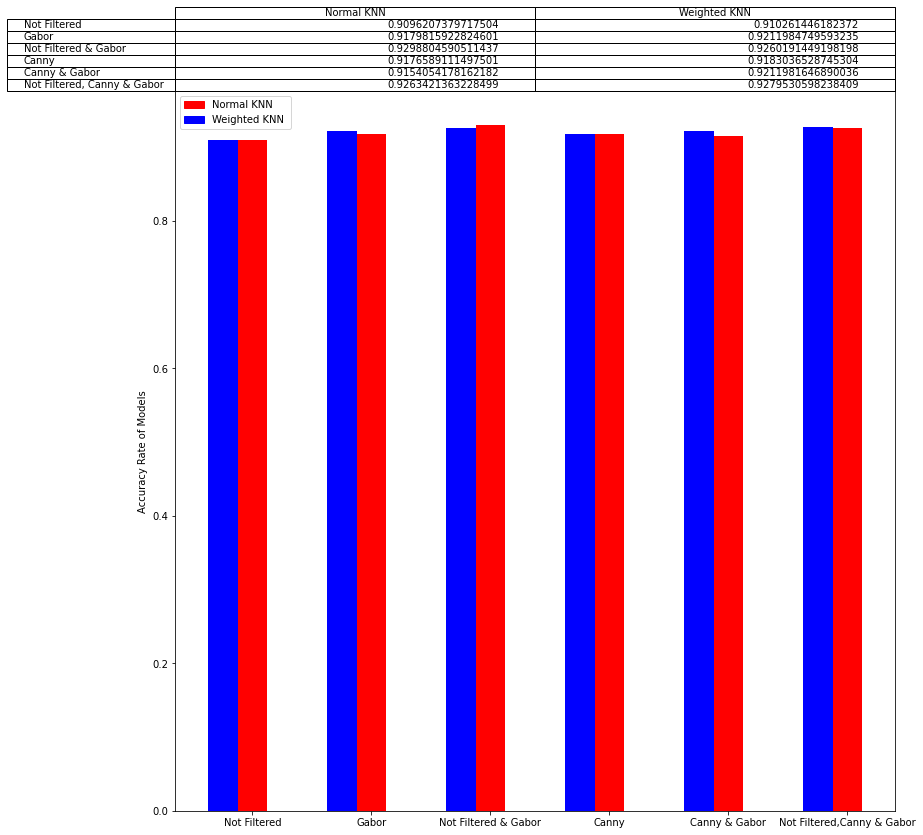

In [384]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0,0,1,1])
langs = ['Not Filtered', 'Gabor', 'Not Filtered & Gabor', 'Canny', 'Canny & Gabor', 'Not Filtered,Canny & Gabor']

weighted_knn_accuracy = [weighted_not_filtered_knn_accuracy,
                         weighted_gabor_knn_accuracy,
                         weighted_not_filtered_gabor_knn_accuracy,
                         weighted_canny_knn_accuracy,
                         weighted_canny_gabor_knn_accuracy,
                         not_filtered_weighted_canny_gabor_knn_accuracy]

knn_accuracy = [not_filtered_knn_accuracy, 
                gabor_knn_accuracy, 
                not_filtered_gabor_knn_accuracy, 
                canny_knn_accuracy, 
                canny_gabor_knn_accuracy,
                not_filtered_canny_gabor_knn_accuracy]
barWidth = 0.25

r1 = np.arange(6)
r2 = [x + barWidth for x in r1] 

plt.bar(r1,weighted_knn_accuracy,color='b', width=barWidth )
plt.bar(r2,knn_accuracy,color='r', width=barWidth )
  
plt.ylabel('Accuracy Rate of Models')
  
colors = {'Normal KNN ':'red', 'Weighted KNN ':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.xticks([r + barWidth for r in range(0,6)], langs)

cell_text=np.array([[not_filtered_knn_accuracy, weighted_not_filtered_knn_accuracy],
                     [gabor_knn_accuracy, weighted_gabor_knn_accuracy],
                     [not_filtered_gabor_knn_accuracy, weighted_not_filtered_gabor_knn_accuracy],
                     [ canny_knn_accuracy, weighted_canny_knn_accuracy],
                     [canny_gabor_knn_accuracy, weighted_canny_gabor_knn_accuracy],
                     [not_filtered_canny_gabor_knn_accuracy, not_filtered_weighted_canny_gabor_knn_accuracy]])

plt.table(cellText=cell_text,
          rowLabels=("Not Filtered", "Gabor", "Not Filtered & Gabor","Canny",  "Canny & Gabor", "Not Filtered, Canny & Gabor"),
          colLabels=("Normal KNN", "Weighted KNN"), loc='top')

plt.show()

As you can see above, weighted k-nearest neighbour mostly gives the best results in k-fold cross validation. The best result is given by the model which trained with the composed normal image (not filtered) and gabor features dataset, which gives 92.98% and 92.60% accuracy. So, I haven chosen the model which use this dataset, and choose the k value as 7 for Weighted KNN algorithm. I haven't prefer the normal knn altough the accuracy is slightly bigger than weighted, as this difference can be ignoring. 

By using this mode, we can look at the confusion matrix and classification report:

In [242]:
data_df = not_filtered_gabor_composed_data.sample(frac=1).reset_index(drop=True)
test_start_index = int(data_df.shape[0] - data_df.shape[0] * test_split_ratio/10)

#I select k=7 because the best result for not filtered, gabor and canny data weigted knn
knn_algorithm = Weighted_KNN_Classification(7)
knn_algorithm.train(data_df.iloc[:test_start_index,:-1], data_df.iloc[:test_start_index,-1])
prediction_array = knn_algorithm.predict(data_df.iloc[test_start_index:,:-1])

#I convert to numpy and reshape the result because the confusion matrix and classification report use numpy array
y_pred = prediction_array.to_numpy().reshape(prediction_array.shape[0],-1)

# For classsification report, Label 1 equals to COVID, Label 2 equals to NORMAL, and Label 3 equals to Viral Pheinomenia
print(confusion_matrix(data_df.iloc[test_start_index:,-1], y_pred))
print(classification_report(data_df.iloc[test_start_index:,-1], y_pred))
print("Accuracy:", accuracy(prediction_array, data_df.iloc[test_start_index:,-1]))

[[261   3  12]
 [  3 325  19]
 [  7  22 281]]
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.95       276
         2.0       0.93      0.94      0.93       347
         3.0       0.90      0.91      0.90       310

    accuracy                           0.93       933
   macro avg       0.93      0.93      0.93       933
weighted avg       0.93      0.93      0.93       933

Accuracy: 0.9292604501607717


#### Confusion Matrix:
As you can see above, If we look at the confusion matrix, the number of the false predicted values mostly occured for viral phenomenia and normal predictions,
- For covid labeled dataset, 15 of 276 data are predicted false. 12 data are predicted as Viral, and 3 data predicted as Normal wrongly.
- For normal labeled dataset, 22 of 347 data are predicted false. 19 data are predicted as Viral, while this is a Normal labeled data.
- For viral pheinomenia dataset, 29 of 310 data are predicted false. 22 data are predicted as Normal, while this is a Viral labeled data.

#### Classification Report:
If we look at the classification report covid predictions has given us the best result, 
- For COVID dataset, 95% of all COVID dataset predicted as true, and 96% of the model's prediction about COVID labels are real COVID data.  
- For NORMAL dataset, 94% of all NORMAL dataset predicted as true, and 93% of the model's prediction about NORMAL labels are real NORMAL data.
- For Viral Pheinomenia dataset, 91% of all Viral Pheinomenia dataset predicted as true, and 90% of the model's prediction about Viral Pheinomenia labels are real Viral Pheinomenia data.


We can say that, our model mostly confuse to predict normal and viral labels. The cause of this, these images mostly looks same to each other. In other words, its pixel values are mostly close to each other. You can see some of the pictures that predicted wrongly for both normal and viral labels:

In [359]:
# To find false negatives for normal labeled data

prediction_row_index_label_df = pd.DataFrame(data=knn_algorithm.prediction_and_row_index_list,
                                          columns=["Index", "Predicted Labels"])
# Add actual label to dataframe
prediction_row_index_label_df["Actual Labels"] = data_df.iloc[test_start_index:,-1].reset_index(drop=True).to_frame()

# Filter actual label is Normal Phenomenia but predicted as Viral
predicted_as_viral_rows_df = prediction_row_index_label_df[prediction_row_index_label_df["Actual Labels"] != prediction_row_index_label_df["Predicted Labels"]]
predicted_as_viral_rows_df = predicted_as_covid_rows_df[prediction_row_index_label_df["Actual Labels"] ==2]
predicted_as_viral_rows_df = predicted_as_covid_rows_df[prediction_row_index_label_df["Predicted Labels"] ==3]

# Filter actual label is Viral Phenomenia but predicted as Normal
predicted_as_normal_rows_df = prediction_row_index_label_df[prediction_row_index_label_df["Actual Labels"] != prediction_row_index_label_df["Predicted Labels"]]
predicted_as_normal_rows_df = predicted_as_normal_rows_df[prediction_row_index_label_df["Actual Labels"] ==3]
predicted_as_normal_rows_df = predicted_as_normal_rows_df[prediction_row_index_label_df["Predicted Labels"] ==2]

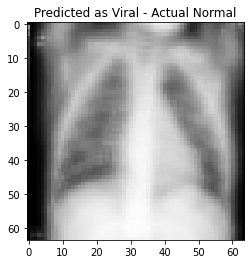

In [368]:
plt.imshow(data_df.iloc[predicted_as_normal_rows_df.iloc[0,0],SIZE*SIZE:-2].to_numpy().reshape(SIZE, SIZE), cmap='gray')
plt.title('Predicted as Viral - Actual Normal'); 

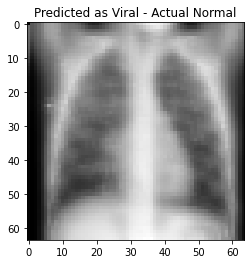

In [369]:
plt.imshow(data_df.iloc[predicted_as_normal_rows_df.iloc[1,0],SIZE*SIZE:-2].to_numpy().reshape(SIZE, SIZE), cmap='gray')
plt.title('Predicted as Viral - Actual Normal'); 

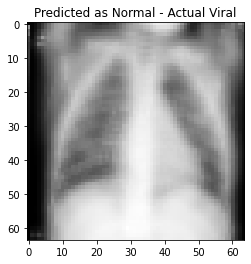

In [366]:
plt.imshow(data_df.iloc[predicted_as_normal_rows_df.iloc[0,0],SIZE*SIZE:-2].to_numpy().reshape(SIZE, SIZE), cmap='gray')
plt.title('Predicted as Normal - Actual Viral'); 

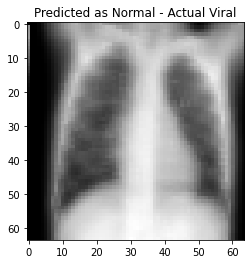

In [367]:
plt.imshow(data_df.iloc[predicted_as_normal_rows_df.iloc[2,0],SIZE*SIZE:-2].to_numpy().reshape(SIZE, SIZE), cmap='gray')
plt.title('Predicted as Normal - Actual Viral'); 

As a conclusion, 
- In Validation of Performance part, the test time has increased while the number of features are increased. We can say that, the K-Nearest Neighbour is not memory and CPU friend algorithm. This because, the matrix operations are costly computed while the number of columns are increasing, and, the training part is just loading of all data on memory. 

- The gabor filters gives the better results than canny edge detection. Usage of this featuring operation in image classification can be more preferable.

- If we look at the weighted knn classification , its prediction is more accurate as the nearest points are weighted as according to distances from the predicted point.

